In [1]:
import numpy as np
import scipy as sp
import matplotlib as mp
import pickle
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner
from itertools import product
%matplotlib inline

In [2]:
sys.path.append('../ligbind/')
import ligbind as lb

In [3]:
def wym_obj(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)

def fit_wym(guess,model,data,ligs,rtot,bnds):
        return sp.optimize.least_squares(wym_obj,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14)
    
def wym_obj_wt(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)/datac

def fit_wym_wt(guess,model,data,ligs,rtot,bnds):
        return sp.optimize.least_squares(wym_obj_wt,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14)

In [4]:
def wymfunc_fix(parm,lig,rtot):
    '''
    Model function for dimerizing, single-site receptors as derived in
    (Wyman and Gill, Binding and Linkage, 1990) and used by
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations,
    and total receptor concentration. Returns the fraction of receptor bound to ligand.

    To generate a data set, iterate over an array of desired receptor concentrations, e.g.:
    [wymfunc(parm,lig,i) for i in array_of_rtots]

    For use in curve fitting an objective function for use with scipy.optimize.least_squares
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)
    '''

    #ensure dimension/broadcasting compatibility of inputs
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        rtot = rtot[:,None] #adds dimension so that it can be broadcast
    else:
        rtot = rtot

    #unpack parameters
    k11 = parm[0]
    k21 = parm[1]
    k22 = k21/4.
    l20 = parm[2]

    ### START MODEL FUNCTION ###

    #calculate concentration of free (unoccupied) receptor
    rfree = (((-1 - k11*lig)) + \
    ((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))**0.5) \
    / (4*l20*(1 + k21*lig + k21*k22*(np.square(lig))))

    #calculate bound fraction
    bfrac = (k11*lig + l20*k21*rfree*lig + \
    2*l20*k21*k22*rfree*(np.square(lig))) \
    / (1 + 2*l20*rfree + k11*lig + \
    2*l20*k21*rfree*lig + 2*l20*k21*k22*rfree*(np.square(lig)))

    ### END MODEL FUNCTION ###

    #flatten output
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        return bfrac.flatten()
    elif (rtot.ndim == 0):
        return bfrac.flatten()
    else:
        return np.concatenate(bfrac)

In [5]:
def randomparms(pop):
    return np.random.choice(pop,4) * np.random.random_sample(4)

In [6]:
#randparmset = np.array([randomparms(np.array([0.1,1.,10.,100.,1000.,10000.])) for i in range(60000)])

In [7]:
#with open("randparmset.pickle", 'wb') as f:
#   pickle.dump(randparmset,f)

In [8]:
with open("randparmset.pickle", 'rb') as f:
    randparmset = pickle.load(f)

In [9]:
randparmset_fix = np.array([np.append(i[0:2],i[-1]) for i in randparmset])

In [10]:
lsbnds = (tuple(1e-6 for i in range(4)),tuple(1e4 for i in range(4)))
lsbnds_fix = (tuple(1e-6 for i in range(3)),tuple(1e4 for i in range(3)))

In [11]:
#sim_n05_pre = [lb.WymSim(sets=1,reps=1,parms=i,noise=0.05) for i in randparmset]

In [12]:
#with open("sim_n05_pre.pickle", 'wb') as f:
#   pickle.dump(sim_n05_pre,f)

In [13]:
with open("sim_n05_pre.pickle", 'rb') as f:
    sim_n05_pre= pickle.load(f)

In [14]:
#full_full_wt_REAL = np.array([np.array([fit_wym_wt(randparmset[j],lb.models.wymfunc,sim_n05_pre[j].meanset[i],sim_n05_pre[j].ligs,sim_n05_pre[j].rtot,lsbnds) for i in range(1)]) for j in range(len(sim_n05_pre))])
#full_fix_wt_REAL = np.array([np.array([fit_wym_wt(randparmset_fix[j],wymfunc_fix,sim_n05_pre[j].meanset[i],sim_n05_pre[j].ligs,sim_n05_pre[j].rtot,lsbnds_fix) for i in range(1)]) for j in range(len(sim_n05_pre))])

In [15]:
#with open("full_full_wt_REAL.pickle", 'wb') as f:
#   pickle.dump(full_full_wt_REAL,f)

In [16]:
#with open("full_fix_wt_REAL.pickle", 'wb') as f:
#    pickle.dump(full_fix_wt_REAL,f)

In [17]:
with open("full_full_wt_REAL.pickle", 'rb') as f:
    full_full_wt_REAL = pickle.load(f)

In [18]:
with open("full_fix_wt_REAL.pickle", 'rb') as f:
    full_fix_wt_REAL = pickle.load(f)

In [19]:
def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [20]:
ps_full= np.array([np.array([ftest(full_fix_wt_REAL[j][i],full_full_wt_REAL[j][i])[-1] for i in range(1)]) for j in range(60000)])

In [21]:
np.sum(ps_full > 0.05)

29136

In [22]:
coop = randparmset[:,1]/randparmset[:,2]
mag = randparmset[:,0]/randparmset[:,1]
lmag = randparmset[:,3]/randparmset[:,0]

In [23]:
newp = np.insert(randparmset,4,coop,axis=1)
newp = np.insert(newp,5,mag,axis=1)
newp = np.insert(newp,6,lmag,axis=1)

In [24]:
rows = np.random.randint(0,60000,1000)

In [25]:
#samp = np.array([newp[i] for i in rows])
samp = newp[rows]
psamp = ps_full[rows]

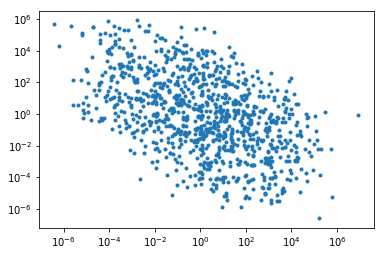

In [26]:
plt.loglog(samp[:,4],samp[:,5],'.')

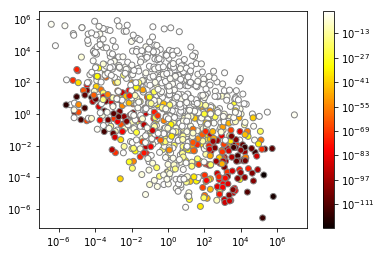

In [27]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
z = psamp
im = ax.scatter(samp[:,4],samp[:,5],c=z,norm=mp.colors.LogNorm(vmin=z.min(), vmax=z.max()),cmap='hot',edgecolors='grey')
fig.colorbar(im,ax=ax)

In [28]:
derb = psamp.copy()

In [29]:
derb[derb < 0.001] = 0.001

In [30]:
derb.min()

0.001

In [31]:
derb

array([[ 0.001     ],
       [ 0.001     ],
       [ 0.11642259],
       [ 0.001     ],
       [ 0.69446575],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.97750821],
       [ 0.76217138],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.14273875],
       [ 0.001     ],
       [ 0.8870854 ],
       [ 0.79188947],
       [ 0.001     ],
       [ 0.2034699 ],
       [ 0.87536929],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.63874611],
       [ 1.        ],
       [ 0.55483298],
       [ 0.001     ],
       [ 0.40069952],
       [ 0.07542472],
       [ 0.001     ],
       [ 0.3586549 ],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.37301762],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.93724984],
       [ 0.04114211],
       [ 0.001     ],
       [ 0.85437617],
       [ 0.001     ],
       [ 0.9338608 ],
       [ 0.83719214],
       [ 0.00970909],
       [ 0.36115729],
       [ 0

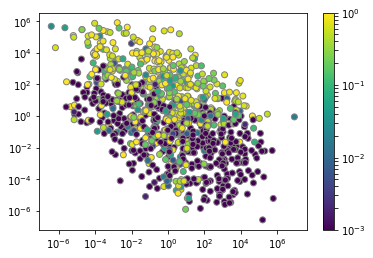

In [32]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
z = derb
im = ax.scatter(samp[:,4],samp[:,5],c=z,norm=mp.colors.LogNorm(vmin=z.min(), vmax=z.max()),cmap='viridis',edgecolors='grey')
fig.colorbar(im,ax=ax)

In [33]:
lerb = psamp.copy()

In [34]:
lerb[lerb < 0.05] = 0.05

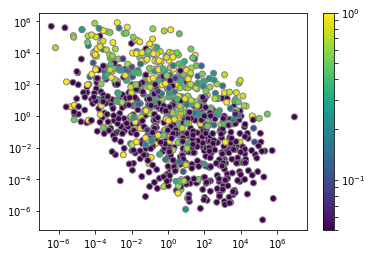

In [35]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
z = lerb
im = ax.scatter(samp[:,4],samp[:,5],c=z,norm=mp.colors.LogNorm(vmin=z.min(), vmax=z.max()),cmap='viridis',edgecolors='grey')
fig.colorbar(im,ax=ax)

In [36]:
cerb = psamp.copy()

In [37]:
cerb[cerb < 0.05] = 0.05

In [38]:
cerb[cerb > 0.05] = 1.

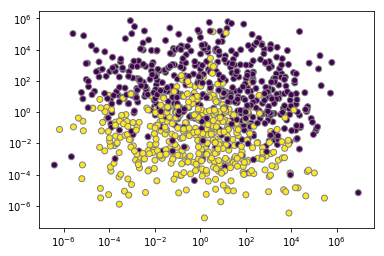

In [39]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
z = cerb
im = ax.scatter(samp[:,4],samp[:,6],c=z,edgecolors='grey')
#fig.colorbar(im,ax=ax)

In [182]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [188]:
ob = PCA(n_components=2)

In [189]:
pcs = ob.fit_transform(scale(newp[:,4:7]))

In [192]:
x = pcs[:,0][rows]
y = pcs[:,1][rows]

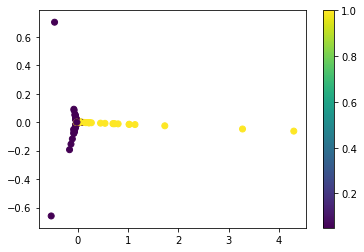

In [197]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
#ax.set_xscale('log')
z = cerb
im = ax.scatter(x,y,c=z)
fig.colorbar(im,ax=ax)

In [201]:
ob.components_[0]

array([-0.5019872 ,  0.73381742, -0.45773448])